# Task 1

In [1]:
from collections import defaultdict, Counter, deque
from typing import Dict, Set, Tuple, List, Iterator
from dataclasses import dataclass
from Bio import SeqIO

@dataclass
class Edge:
    target: str
    label: str  # The last base of the target k-mer

class DeBruijnGraph:
    def __init__(self):
        self.kmer_counts: Counter = Counter()  # node coverage
        self.adj: Dict[str, List[Edge]] = defaultdict(list)  # adjacency list

    def add_kmer(self, kmer: str, coverage: int = 1):
        self.kmer_counts[kmer] += coverage

    def add_edge(self, source: str, target: str, label: str):
        self.adj[source].append(Edge(target, label))

    def nodes(self) -> Set[str]:
        return set(self.kmer_counts.keys())

    def in_degree(self) -> Dict[str, int]:
        in_degrees = Counter()
        for source_node, edges in self.adj.items():
            for e in edges:
                in_degrees[e.target] += 1
        for node in self.kmer_counts:
            if node not in in_degrees:
                in_degrees[node] = 0
        return in_degrees

    def out_degree(self) -> Dict[str, int]:
        out_degrees = {node: len(edges) for node, edges in self.adj.items()}
        for node in self.kmer_counts:
            if node not in out_degrees:
                out_degrees[node] = 0
        return out_degrees

def stream_kmers_from_fastq(fastq_path: str, k: int) -> Iterator[Tuple[str, str]]:
    """Yields (k-mer, next_k-mer) pairs from the FASTQ file."""
    for record in SeqIO.parse(fastq_path, "fastq"):
        seq = str(record.seq)
        for i in range(len(seq) - k):
            kmer = seq[i:i+k]
            next_kmer = seq[i+1:i+k+1]
            yield (kmer, next_kmer)

        # Add the last k-mer 
        if len(seq) >= k:
            yield (seq[-k:], None)

def build_debruijn_graph(fastq_path: str, k: int) -> DeBruijnGraph:
    """
    Builds a De Bruijn graph from a FASTQ file.
    """
    dbg = DeBruijnGraph()
    for kmer, next_kmer in stream_kmers_from_fastq(fastq_path, k):
        dbg.add_kmer(kmer)
        if next_kmer:
            dbg.add_edge(kmer, next_kmer, label=next_kmer[-1])
    return dbg

In [2]:
def test_build_debruijn_graph():
    """
    Self-test for De Bruijn graph construction.
    """
    # Synthetic reads covering sequence: ATGAC
    # k = 3, expected k-mers: ATG, TGA, GAC
    # edges: ATG->TGA (label 'A'), TGA->GAC (label 'C')
    reads = ["ATGAC"]
    k = 3

    # Write reads to temporary FASTQ file
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.fastq') as tmp:
        for i, seq in enumerate(reads):
            tmp.write(f"@read{i}\n{seq}\n+\n{'I'*len(seq)}\n")
        tmp.flush()

        # Build graph
        dbg = build_debruijn_graph(tmp.name, k)

    # Expected k-mers and counts
    expected_kmers = {"ATG", "TGA", "GAC"}
    for kmer in expected_kmers:
        assert dbg.kmer_counts[kmer] == 1, f"K-mer {kmer} coverage incorrect."

    # Expected edges and labels_list
    expected_edges = {
        "ATG": [("TGA", "A")],
        "TGA": [("GAC", "C")]
    }
    for source_node, edges in expected_edges.items():
        assert source_node in dbg.adj, f"Source node {source_node} missing in adjacency."
        adj_edges = dbg.adj[source_node]
        assert len(adj_edges) == len(edges), f"Incorrect number of edges from {source_node}."
        for target, label in edges:
            found = any(e.target == target and e.label == label for e in adj_edges)
            assert found, f"Edge {source_node}->{target} with label {label} not found."

    print("De Bruijn graph build test passed.")



# Task 2

In [3]:
def compress_debruijn_graph(graph: DeBruijnGraph) -> DeBruijnGraph:
    """Merge maximal non-branching paths in the graph."""
    in_degrees = graph.in_degree()
    out_degrees = graph.out_degree()
    visited: Set[Tuple[str, str]] = set()

    compressed_graph = DeBruijnGraph()
    # carry over node coverage
    compressed_graph.kmer_counts = graph.kmer_counts.copy()

    for node in graph.nodes():
        # Skip nodes with no outgoing edges
        if out_degrees[node] == 0:
            continue

        for edge in graph.adj[node]:
            eid = (node, edge.target)
            if eid in visited:
                continue

            # Start a new path if node is branching or dead end
            if in_degrees[node] != 1 or out_degrees[node] != 1:
                source_node = node
                target_node = edge.target
                labels_list = [edge.label]
                visited.add(eid)


                # Traverse while current node is non-branching
                while in_degrees[target_node] == 1 and out_degrees[target_node] == 1:
                    next_edge = graph.adj[target_node][0]
                    visited.add((target_node, next_edge.target))
                    labels_list.append(next_edge.label)
                    target_node = next_edge.target

                merged_label = ''.join(labels_list)
                compressed_graph.add_edge(source_node, target_node, merged_label)

    # Add isolated nodes with no edges
    for node in graph.nodes():
        if in_degrees[node] == 0 and out_degrees[node] == 0:
            compressed_graph.kmer_counts[node] = graph.kmer_counts[node]

    return compressed_graph

In [4]:
def test_compress_debruijn_graph():
    """
    Self-test for De Bruijn graph compression.
    """
    # Synthetic read covering sequence: ATGCAA
    # k = 3, original k-mers: ATG, TGC, GCA, CAA
    # original edges:
    #   ATG->TGC ('C'), TGC->GCA ('A'), GCA->CAA ('A')
    # after compression: ATG->CAA with label 'CAA'
    reads = ["ATGCAA"]
    k = 3

    # Write reads to temporary FASTQ file
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.fastq') as tmp:
        for i, seq in enumerate(reads):
            tmp.write(f"@read{i}\n{seq}\n+\n{'I'*len(seq)}\n")
        tmp.flush()

        # Build and compress graph
        dbg = build_debruijn_graph(tmp.name, k)
    cdbg = compress_debruijn_graph(dbg)

    # Expected k-mers and counts remain unchanged
    expected_kmers = {"ATG", "TGC", "GCA", "CAA"}
    for kmer in expected_kmers:
        assert cdbg.kmer_counts[kmer] == 1, f"K-mer {kmer} coverage incorrect after compression."

    # Expected compressed_graph edges
    expected_edges = {
        "ATG": [("CAA", "CAA")]
    }
    # Only ATG should have outgoing edges
    assert set(cdbg.adj.keys()) == set(expected_edges.keys()), \
        f"Unexpected sources after compression: {set(cdbg.adj.keys())}"

    for source_node, edges in expected_edges.items():
        adj_edges = cdbg.adj[source_node]
        assert len(adj_edges) == len(edges), f"Incorrect number of edges from {source_node} after compression."
        for target, label in edges:
            found = any(e.target == target and e.label == label for e in adj_edges)
            assert found, f"Edge {source_node}->{target} with label '{label}' not found after compression."

    print("De Bruijn graph compression test passed.")



# Task 3

In [5]:
def remove_tails_debruijn_graph(graph: DeBruijnGraph, percentile: float = 0.3) -> DeBruijnGraph:
    """Remove low-coverage tails from the graph."""
    in_degrees = graph.in_degree()
    out_degrees = graph.out_degree()
    tails = []  # list of (edges_path, metric)

    # 1) collect all tails starting at sources
    for start in graph.nodes():
        if in_degrees[start] != 0 or out_degrees[start] == 0:
            continue
        path_nodes = [start]
        edges_path = []
        curr = start
        while out_degrees[curr] == 1 and in_degrees[curr] <= 1:
            e = graph.adj[curr][0]
            edges_path.append((curr, e))
            curr = e.target
            path_nodes.append(curr)
            if in_degrees[curr] != 1:
                break
        if not edges_path:
            continue
        # metric = avg coverage over nodes * number of edges
        covs = [graph.kmer_counts[n] for n in path_nodes]
        metric = (sum(covs) / len(covs)) * len(edges_path)
        tails.append((edges_path, metric))

    if not tails:
        return graph

    # 2) threshold at given percentile
    metrics = sorted(m for _, m in tails)
    thresh = metrics[int(len(metrics) * percentile)]

    # 3) copy graph
    trimmed_graph = DeBruijnGraph()
    trimmed_graph.kmer_counts = graph.kmer_counts.copy()
    trimmed_graph.adj = {u: list(v) for u, v in graph.adj.items()}

    # 4) remove edges of low-metric tails
    for edges_path, metric in tails:
        if metric <= thresh:
            for source_node, e in edges_path:
                trimmed_graph.adj[source_node] = [
                    edge for edge in trimmed_graph.adj[source_node]
                    if not (edge.target == e.target and edge.label == e.label)
                ]

    # 5) collapse duplicate edges
    for source_node in list(trimmed_graph.adj):
        seen = set()
        unique_edges = []
        for e in trimmed_graph.adj[source_node]:
            key = (e.target, e.label)
            if key not in seen:
                seen.add(key)
                unique_edges.append(e)
        trimmed_graph.adj[source_node] = unique_edges

    return trimmed_graph

In [6]:
def test_remove_tails():
    """
    Self-test for tail removal.
    """
    reads = ["ATGAC", "ATGAC", "CCCAC"]
    k = 3

    # Write reads to temporary FASTQ file
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.fastq') as tmp:
        for i, seq in enumerate(reads):
            tmp.write(f"@r{i}\n{seq}\n+\n{'I'*len(seq)}\n")
        tmp.flush()
        dbg = build_debruijn_graph(tmp.name, k)

    # In this graph:
    # Bottom 30% threshold will remove the CCC tail only.
    trimmed_graph = remove_tails_debruijn_graph(dbg, percentile=0.3)

    # Expected remaining edges come only from the "ATG" tail:
    expected_edges = {
        "ATG": [("TGA", "A")],
        "TGA": [("GAC", "C")]
    }

    # Check that lower tail is gone and higher tail remains
    for source_node, edges in expected_edges.items():
        assert source_node in trimmed_graph.adj, f"Node {source_node} should still have outgoing edges."
        adj_edges = trimmed_graph.adj[source_node]
        assert len(adj_edges) == len(edges), f"Wrong number of edges from {source_node} after trimming."
        for target, label in edges:
            found = any(e.target == target and e.label == label for e in adj_edges)
            assert found, f"Edge {source_node}->{target} with label '{label}' missing."

    # Check that CCC tail edges were removed
    assert "CCC" not in trimmed_graph.adj or trimmed_graph.adj["CCC"] == [], "Low-coverage tail CCC was not removed."

    print("Tail removal test passed.")



# Task 4

In [7]:
def remove_bubbles_debruijn_graph(graph: DeBruijnGraph, k: int) -> DeBruijnGraph:
    """Remove bubbles of length ≤ 2k, keeping higher-coverage branches."""
    in_degrees = graph.in_degree()
    out_degrees = graph.out_degree()
    max_len = 2 * k

    # find all source nodes
    sources = [n for n in graph.nodes() if in_degrees[n] == 0 and out_degrees[n] > 0]
    # record for each sink: list of (source, path_edges, metric)
    sink_paths = defaultdict(list)

    # explore from each source
    for s in sources:
        # BFS over simple paths up to max_len edges
        queue = deque()
        for e in graph.adj.get(s, []):
            queue.append((e.target, [(s, e)]))
        while queue:
            curr, path = queue.popleft()
            if len(path) > max_len:
                continue
            # compute metric for this path
            nodes = [s] + [e.target for _, e in path]
            covs = [graph.kmer_counts[n] for n in nodes]
            metric = (sum(covs) / len(covs)) * len(path)
            sink_paths[curr].append((s, path, metric))
            # extend path
            for e in graph.adj.get(curr, []):
                if e.target in nodes:
                    continue
                queue.append((e.target, path + [(curr, e)]))

    # copy graph
    trimmed_graph = DeBruijnGraph()
    trimmed_graph.kmer_counts = graph.kmer_counts.copy()
    trimmed_graph.adj = {u: list(v) for u, v in graph.adj.items()}

    # for each sink with ≥2 source-paths, prune lower branch
    for sink, entries in sink_paths.items():
        # group best path per source
        best_per_source = {}
        for s, path, m in entries:
            if s not in best_per_source or m > best_per_source[s][1]:
                best_per_source[s] = (path, m)
        if len(best_per_source) < 2:
            continue
        # pick global best
        keep_src, (keep_path, keep_m) = max(best_per_source.items(), key=lambda x: x[1][1])
        # remove all other source paths
        for s, (path, m) in best_per_source.items():
            if s == keep_src:
                continue
            for source_node, e in path:
                trimmed_graph.adj[source_node] = [
                    edge for edge in trimmed_graph.adj.get(source_node, [])
                    if not (edge.target == e.target and edge.label == e.label)
                ]

    return trimmed_graph

In [8]:
def test_remove_bubbles():
    """
    Self-test for bubble removal.
    """
    reads = ["ACGTAC", "ACGTAC", "ACATAC"]
    k = 3

    # Write reads to temporary FASTQ file
    import tempfile
    with tempfile.NamedTemporaryFile(mode='w+', delete=False, suffix='.fastq') as tmp:
        for i, seq in enumerate(reads):
            tmp.write(f"@r{i}\n{seq}\n+\n{'I'*len(seq)}\n")
        tmp.flush()
        dbg = build_debruijn_graph(tmp.name, k)

    # Before trimming there aare two distinct paths into TAC edge
    assert "TAC" in {e.target for edges in dbg.adj.values() for e in edges}
    # Remove bubbles
    trimmed_graph = remove_bubbles_debruijn_graph(dbg, k)

    # The lower-coverage branch starts at ACA and should be gone
    assert "ACA" not in trimmed_graph.adj or trimmed_graph.adj["ACA"] == [], \
        "Bubble branch 'ACA' was not removed."
    
    # The higher-coverage branch from ACG remains
    assert any(e.target == "CGT" for e in trimmed_graph.adj.get("ACG", [])), \
        "Correct branch from 'ACG' was incorrectly removed."

    print("Bubble removal test passed.")



# Task 5

DE BRUIJN GRAPH ANALYSIS
Building graph from ERR008613.fastq.gz (k=31, max_reads=100000)...
Processed 10000 reads...
Processed 20000 reads...
Processed 30000 reads...
Processed 40000 reads...
Processed 50000 reads...
Processed 60000 reads...
Processed 70000 reads...
Processed 80000 reads...
Processed 90000 reads...
Processed 100000 reads...
Processed 100000 reads total
Graph building took 14.1 seconds

=== GRAPH BEFORE SIMPLIFICATIONS ===
Nodes: 5,287,655
Edges: 6,900,000
Coverage - Min: 1, Max: 4028, Avg: 1.3
In-degree - Max: 3995, Avg: 1.3
Out-degree - Max: 3904, Avg: 1.3
Compression took 31.5 seconds

=== AFTER COMPRESSION ===
Nodes: 5,287,655
Edges: 1,388,528
Coverage - Min: 1, Max: 4028, Avg: 1.3
In-degree - Max: 5, Avg: 0.3
Out-degree - Max: 5, Avg: 0.3
Tail removal took 35.7 seconds

=== AFTER TAIL REMOVAL ===
Nodes: 5,287,655
Edges: 1,361,875
Coverage - Min: 1, Max: 4028, Avg: 1.3
In-degree - Max: 5, Avg: 0.3
Out-degree - Max: 5, Avg: 0.3
Bubble removal took 68.8 seconds

=== F

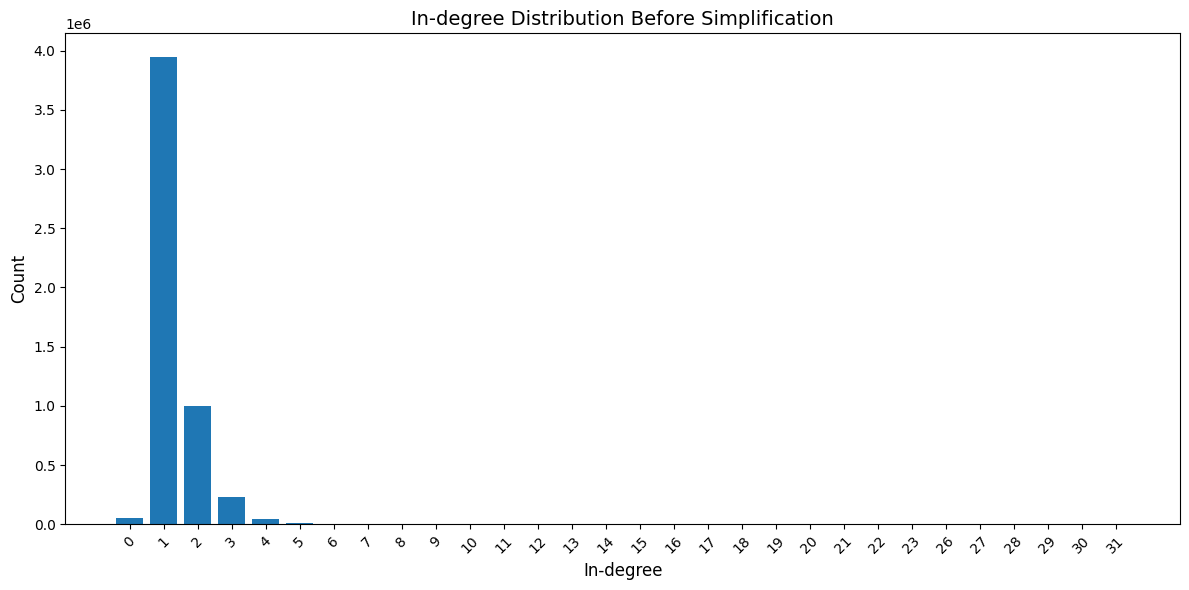

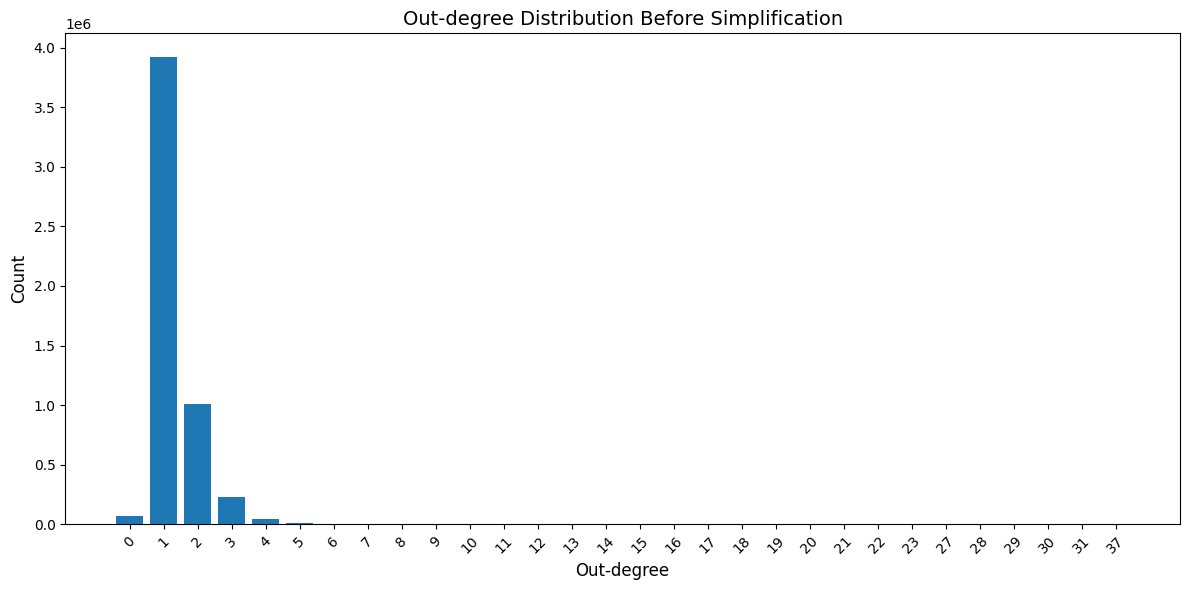

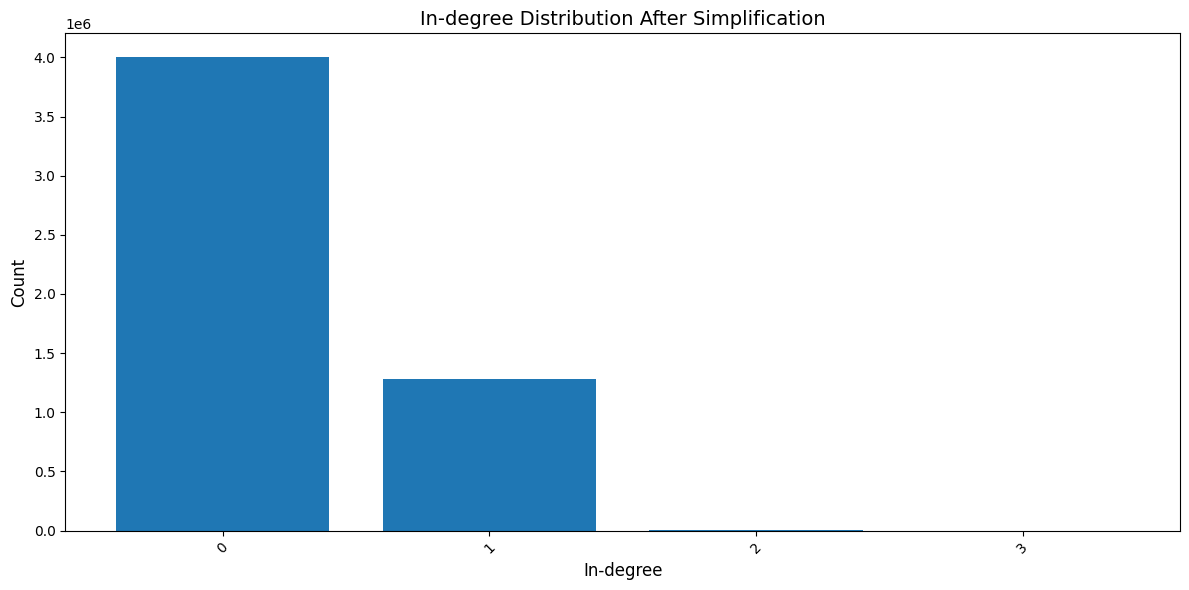

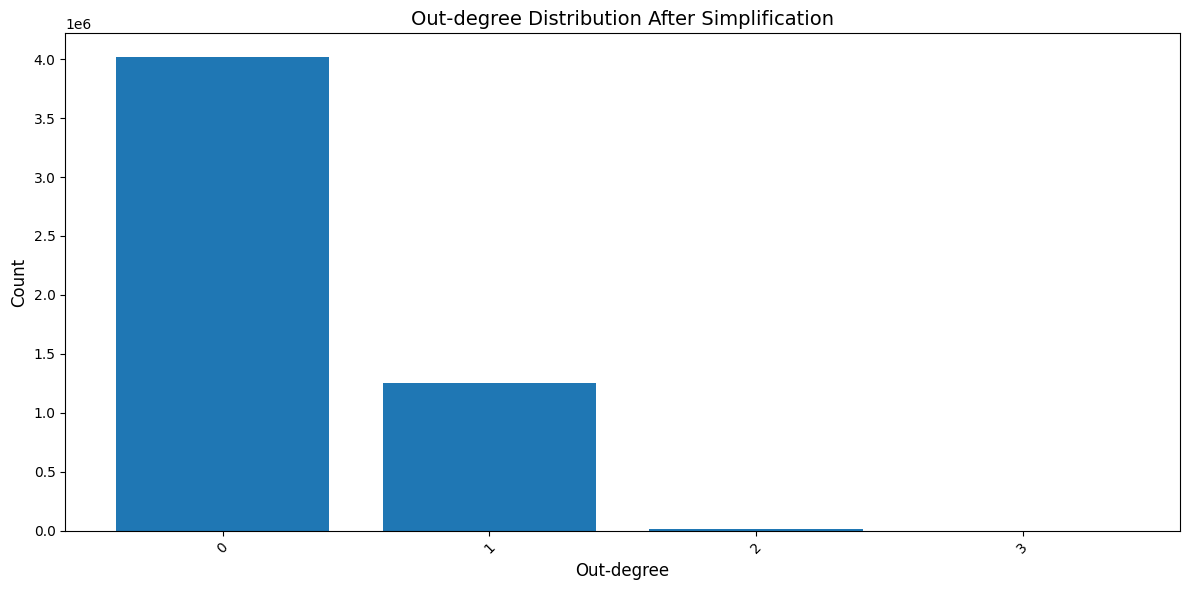

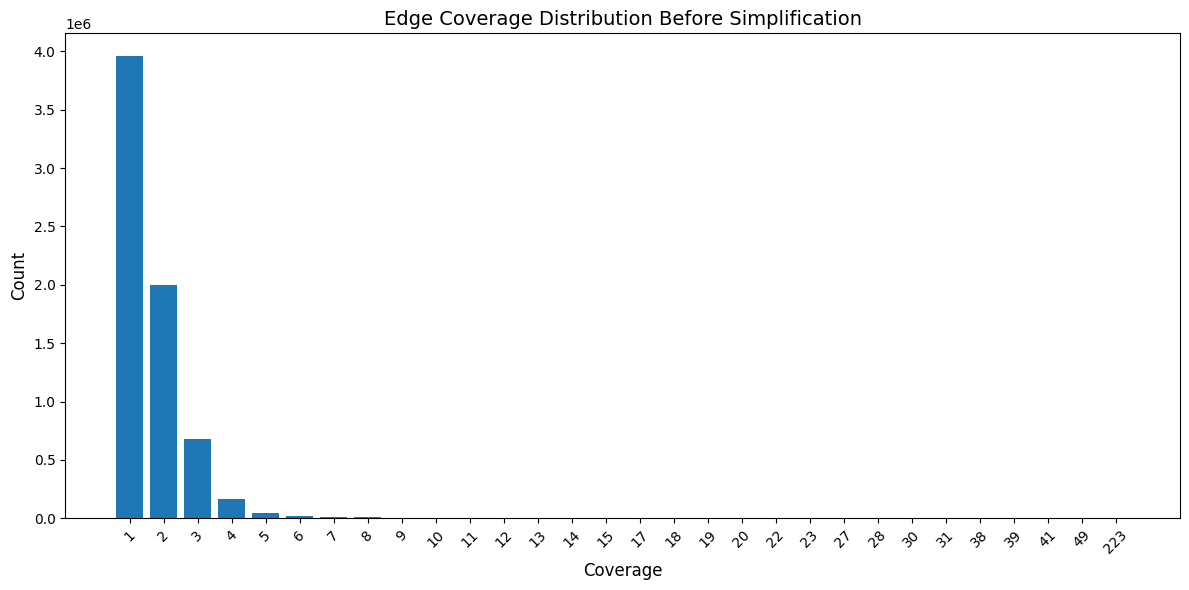

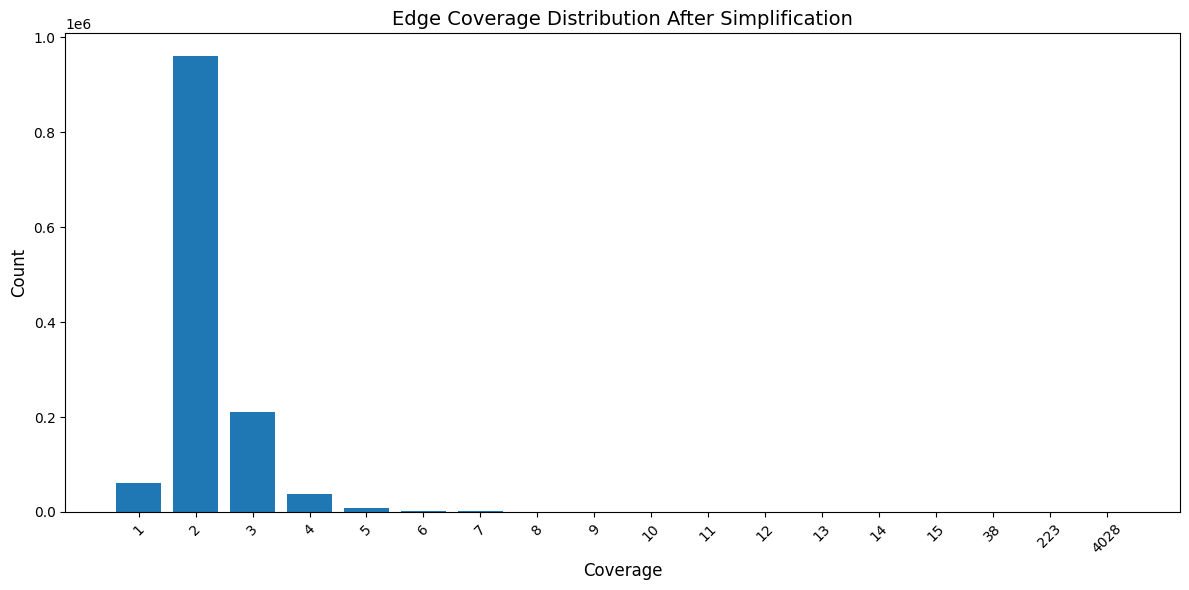


FINAL REDUCTION STATISTICS
Node reduction: 5,287,655 → 5,287,655 (0.0% reduction)
Edge reduction: 6,900,000 → 1,286,116 (81.4% reduction)

Distribution Summaries:
Before - Most common in-degree: (1, 3949431)
Before - Most common out-degree: (1, 3924078)
After - Most common in-degree: (0, 4003133)
After - Most common out-degree: (0, 4018721)
Before - Most common edge coverage: (1, 3955834)
After - Most common edge coverage: (2, 960323)


In [9]:
import gzip
import matplotlib.pyplot as plt
from collections import Counter
import time

def build_graph_from_fastq(fastq_gz_path, k, max_reads):
    """
    Build graph from gzipped FASTQ with read limit (for performance)
    """

    print(f"Building graph from {fastq_gz_path} (k={k}, max_reads={max_reads})...")
    
    dbg = DeBruijnGraph()
    read_count = 0
    
    with gzip.open(fastq_gz_path, "rt") as f:
        record_lines = []
        line_count = 0
        
        for line in f:
            record_lines.append(line.strip())
            line_count += 1
            
            # Process every 4 lines
            if line_count % 4 == 0:
                if len(record_lines) == 4:
                    # Extract sequence from second line
                    seq = record_lines[1]
                    
                    # Process k-mers from this sequence
                    if len(seq) >= k:
                        for i in range(len(seq) - k + 1):
                            kmer = seq[i:i+k]
                            dbg.add_kmer(kmer)
                            
                            # Add edge to next k-mer if exists
                            if i < len(seq) - k:
                                next_kmer = seq[i+1:i+k+1]
                                dbg.add_edge(kmer, next_kmer, label=next_kmer[-1])
                
                record_lines = []
                read_count += 1
                
                # Progress indicator
                if read_count % 10000 == 0:
                    print(f"Processed {read_count} reads...")
                
                # Stop at max_reads limit
                if read_count >= max_reads:
                    break

    print(f"Processed {read_count} reads total")
    return dbg

def count_edges(graph: DeBruijnGraph) -> int:
    """Count total number of edges in the graph."""
    return sum(len(edges) for edges in graph.adj.values())

def edge_coverages(graph: DeBruijnGraph) -> Counter:
    """Calculate edge coverage distribution."""
    covs = []
    for source_node, edges in graph.adj.items():
        src_cov = graph.kmer_counts.get(source_node, 1)
        for e in edges:
            tgt_cov = graph.kmer_counts.get(e.target, 1)
            covs.append(min(src_cov, tgt_cov))
    return Counter(covs)

def plot_distribution(data_counter: Counter, title: str, xlabel: str, ylabel: str):
    # Limit to top 30 values for readability
    items = sorted(data_counter.items())[:30]
        
    x, y = zip(*items)
    
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(x)), y)
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    
    # Set x-axis labels_list
    plt.xticks(range(len(x)), [str(xi) for xi in x], rotation=45)
    plt.tight_layout()
    plt.show()

def print_graph_stats(graph: DeBruijnGraph, label: str):
    """Print graph statistics."""
    nodes = len(graph.nodes())
    edges = count_edges(graph)
    
    print(f"\n=== {label} ===")
    print(f"Nodes: {nodes:,}")
    print(f"Edges: {edges:,}")
    
    if nodes > 0:
        # Coverage statistics
        coverages = list(graph.kmer_counts.values())
        print(f"Coverage - Min: {min(coverages)}, Max: {max(coverages)}, Avg: {sum(coverages)/len(coverages):.1f}")
        
        # Degree statistics
        in_degrees = list(graph.in_degree().values())
        out_degrees = list(graph.out_degree().values())
        print(f"In-degree - Max: {max(in_degrees)}, Avg: {sum(in_degrees)/len(in_degrees):.1f}")
        print(f"Out-degree - Max: {max(out_degrees)}, Avg: {sum(out_degrees)/len(out_degrees):.1f}")

def main():
    # Parameters
    fastq_path = "ERR008613.fastq.gz"
    k = 31
    max_reads = 100_000  # Limit reads for performance
    
    print("="*60)
    print("DE BRUIJN GRAPH ANALYSIS")
    print("="*60)
    
    # 1. Build initial graph (before simplifications)
    start_time = time.time()
    graph_before = build_graph_from_fastq(fastq_path, k, max_reads)
    build_time = time.time() - start_time
    print(f"Graph building took {build_time:.1f} seconds")
    
    print_graph_stats(graph_before, "GRAPH BEFORE SIMPLIFICATIONS")
    
    # 2, Apply simplifications

    start_time = time.time()
    graph_compressed = compress_debruijn_graph(graph_before)
    compress_time = time.time() - start_time
    print(f"Compression took {compress_time:.1f} seconds")
    print_graph_stats(graph_compressed, "AFTER COMPRESSION")
    
    start_time = time.time()
    graph_no_tails = remove_tails_debruijn_graph(graph_compressed)
    tail_time = time.time() - start_time
    print(f"Tail removal took {tail_time:.1f} seconds")
    print_graph_stats(graph_no_tails, "AFTER TAIL REMOVAL")
    
    start_time = time.time()
    graph_after = remove_bubbles_debruijn_graph(graph_no_tails, k)
    bubble_time = time.time() - start_time
    print(f"Bubble removal took {bubble_time:.1f} seconds")
    print_graph_stats(graph_after, "FINAL GRAPH AFTER ALL SIMPLIFICATIONS")
    
    # 3. Calculate distributions
    indeg_before = Counter(graph_before.in_degree().values())
    outdeg_before = Counter(graph_before.out_degree().values())
    indeg_after = Counter(graph_after.in_degree().values())
    outdeg_after = Counter(graph_after.out_degree().values())
    edge_cov_before = edge_coverages(graph_before)
    edge_cov_after = edge_coverages(graph_after)
    
    # 4. Generate plots    
    plot_distribution(indeg_before, "In-degree Distribution Before Simplification", "In-degree", "Count")
    plot_distribution(outdeg_before, "Out-degree Distribution Before Simplification", "Out-degree", "Count")
    plot_distribution(indeg_after, "In-degree Distribution After Simplification", "In-degree", "Count")
    plot_distribution(outdeg_after, "Out-degree Distribution After Simplification", "Out-degree", "Count")
    
    plot_distribution(edge_cov_before, "Edge Coverage Distribution Before Simplification", "Coverage", "Count")
    plot_distribution(edge_cov_after, "Edge Coverage Distribution After Simplification", "Coverage", "Count")
    
    # 5. Print final reduction statistics
    nodes_before = len(graph_before.nodes())
    nodes_after = len(graph_after.nodes())
    edges_before = count_edges(graph_before)
    edges_after = count_edges(graph_after)
    
    print("\n" + "="*60)
    print("FINAL REDUCTION STATISTICS")
    print("="*60)
    print(f"Node reduction: {nodes_before:,} → {nodes_after:,} ({100*(nodes_before-nodes_after)/nodes_before:.1f}% reduction)")
    print(f"Edge reduction: {edges_before:,} → {edges_after:,} ({100*(edges_before-edges_after)/edges_before:.1f}% reduction)")
    
    # Summary
    print(f"\nDistribution Summaries:")
    print(f"Before - Most common in-degree: {indeg_before.most_common(1)[0] if indeg_before else 'None'}")
    print(f"Before - Most common out-degree: {outdeg_before.most_common(1)[0] if outdeg_before else 'None'}")
    print(f"After - Most common in-degree: {indeg_after.most_common(1)[0] if indeg_after else 'None'}")
    print(f"After - Most common out-degree: {outdeg_after.most_common(1)[0] if outdeg_after else 'None'}")
    
    if edge_cov_before:
        print(f"Before - Most common edge coverage: {edge_cov_before.most_common(1)[0]}")
    if edge_cov_after:
        print(f"After - Most common edge coverage: {edge_cov_after.most_common(1)[0]}")

    return graph_after

if __name__ == "__main__":
    graph_after = main()
        



# Task 6

In [10]:
def extract_contigs_debruijn_graph(graph):
    """
    Return all contig sequences from a simplified De Bruijn graph.
    """
    in_degrees = graph.in_degree()
    out_degrees = graph.out_degree()
    contigs: List[str] = []
    visited: Set[Tuple[str, str]] = set()  

    # 1) Maximal non-branching paths
    for node in graph.nodes():
        # start at any node that is not 1-in-1-out but has outgoing edges
        if out_degrees[node] > 0 and (in_degrees[node] != 1 or out_degrees[node] != 1):
            for edge in graph.adj[node]:
                if (node, edge.target) in visited:
                    continue
                seq = node               # initialize with full k-mer
                curr = edge
                visited.add((node, curr.target))
                seq += curr.label        # append the extra base

                # extend while single-in single-out
                while in_degrees[curr.target] == 1 and out_degrees[curr.target] == 1:
                    nxt = graph.adj[curr.target][0]
                    visited.add((curr.target, nxt.target))
                    seq += nxt.label
                    curr = nxt

                contigs.append(seq)

    # 2) Isolated cycles
    for node in graph.nodes():
        if in_degrees[node] == 1 and out_degrees[node] == 1:
            start = node
            cycle_seq = node
            curr = graph.adj[node][0]
            if (node, curr.target) in visited:
                continue
            visited.add((node, curr.target))
            cycle_seq += curr.label
            curr_node = curr.target
            while curr_node != start:
                e = graph.adj[curr_node][0]
                visited.add((curr_node, e.target))
                cycle_seq += e.label
                curr_node = e.target
            contigs.append(cycle_seq)

    return contigs


contigs = extract_contigs_debruijn_graph(graph_after)
# sort by length descending
contigs.sort(key=len, reverse=True)

# three longest:
print("\nTop 3 contigs:")
for i, seq in enumerate(contigs[:3], 1):
    print(f"{i}: length={len(seq)}\n{seq}")


Top 3 contigs:
1: length=495
ATAAAAAATAAAGCAATCATTACCATCAGATAGGTTGATCGTGGAACAACTTCCTCAACGCCTGGCTGATTAAACCAACTATTCACCAAAACCAAAGCAAGCCCAAACAATAAGCTCACTAATACAGTACTACTAATTCTCAAATAGTCTTTTTCCATAAAGCTACACCAATCTGTAGGTTGTAGATCCCTTTCTATTATTAATAGATATAAGAACTGTACTGTTGTCAATATGAAATTCCGCCCACAAACAATACCGATGATGATAGTTGCTGAATGTAATTATTATTGCCTAAGTGCTTTATACATTGTTTGCAACAAGCCAGGCTTGAAAATACTTATAAATGGTTATAGAAAATCCTTATAAAACATTAATTCATAGATACATTAGGAATAACAATTAAATCCGTGAGTGCCGTAGCGCAGCCTTTCATCAGGACTTTCGAAAAATCCGAAATCATGCATCGGAATTTACTGATTTAATTATTTTAATCCT
2: length=452
GTTACAGTAAACGAAGCAACATTCTGTGGCCTACGCCGATCAAAAGCTCTGTGAAAATTTCCCTTGTTGTCTTTGTCTGACCTTATCGCGGCGATCAGCAATTATTCGTTTTGTGATCCTCAACACAAAATGCTATTCGTCGCCTATGAGGGGAGAAGAATTTATGGAAAACGATTGCATTCACAAAATGACGTCCTGTCAGAAGAGAAAAAGTTGACGTTAATCAATTGTTCGAGATGATCAATACATGTATTCGAAATTTTAAAATATTGATAAAATAAATGTTTGTTCTCCAACAAATAGCGTGAAAAAATGTGACATGCCGCATTATTTATCACTGAAAATGGTTTATTTATAATAAAATTTGAGAACTTGCTCATTAAATTTAACTCAAATTTTGCCTGGTAATTATCCGGTAATTGCTTGAAATATGGTCTCAGCCCCTTTTTTGT
3: leng

# BLAST results

## Summary

| Contig num | Length (bp) | Description                                                             | % Identities | Query Coverage | E-value |
|-----------:|------------:|:------------------------------------------------------------------------|-------------:|---------------:|--------:|
| 1          | 495         | Escherichia coli strain ETEC1730 chromosome, complete genome             | 100.0%       | 100%           | 0.0     |
| 2          | 452         | Escherichia coli strain ETEC1730 chromosome, complete genome             | 100.0%       | 100%           | 0.0     |
| 3          | 441         | Escherichia coli strain ETEC1730 chromosome, complete genome             | 100.0%       | 100%           | 0.0     |


## Conclusion

All contigs ideally mapped on  Escherichia coli strain ETEC1730.